In [1]:
!kaggle datasets download -d muhammadhananasghar/oace-open-and-close-eyes-dataset

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/oace-open-and-close-eyes-dataset
License(s): CC0-1.0
100% 517M/518M [00:07<00:00, 72.1MB/s]
100% 518M/518M [00:07<00:00, 69.0MB/s]


In [2]:
!unzip oace-open-and-close-eyes-dataset.zip -d ./oace_dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./oace_dataset/OACE/open/9ef29e84-9e4f-11ec-9081-842b2bb3a5b6.jpg  
  inflating: ./oace_dataset/OACE/open/9ef39e45-9e4f-11ec-91f2-842b2bb3a5b6.jpg  
  inflating: ./oace_dataset/OACE/open/9ef4b655-9e4f-11ec-a3d5-842b2bb3a5b6.jpg  
  inflating: ./oace_dataset/OACE/open/9ef5b839-9e4f-11ec-89dc-842b2bb3a5b6.jpg  
  inflating: ./oace_dataset/OACE/open/9ef6b9ca-9e4f-11ec-a9f4-842b2bb3a5b6.jpg  
  inflating: ./oace_dataset/OACE/open/9ef8111d-9e4f-11ec-a3a5-842b2bb3a5b6.jpg  
  inflating: ./oace_dataset/OACE/open/9ef91715-9e4f-11ec-8c90-842b2bb3a5b6.jpg  
  inflating: ./oace_dataset/OACE/open/9efa1b02-9e4f-11ec-afea-842b2bb3a5b6.jpg  
  inflating: ./oace_dataset/OACE/open/9efb14bd-9e4f-11ec-9923-842b2bb3a5b6.jpg  
  inflating: ./oace_dataset/OACE/open/9efc076b-9e4f-11ec-8329-842b2bb3a5b6.jpg  
  inflating: ./oace_dataset/OACE/open/9efd64dd-9e4f-11ec-8c51-842b2bb3a5b6.jpg  
  inflating: ./oace_dataset/OACE/open/9efe5bbe-9e4f-11ec-b

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

In [5]:
def split_data(data_dir, output_dir, train_size=0.7, val_size=0.15, test_size=0.15, seed=42):


    assert train_size + val_size + test_size == 1, "Train, validation, and test sizes must sum to 1."

    classes = ['close', 'open']

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        images = os.listdir(class_dir)
        images = [img for img in images if img.endswith(('.png', '.jpg', '.jpeg'))]

        train_images, temp_images = train_test_split(images, train_size=train_size, random_state=seed)
        val_images, test_images = train_test_split(temp_images, train_size=val_size/(val_size + test_size), random_state=seed)

        for subset, subset_images in zip(['train', 'validation', 'test'], [train_images, val_images, test_images]):
            output_subset_dir = os.path.join(output_dir, subset, class_name)
            os.makedirs(output_subset_dir, exist_ok=True)

            for img in subset_images:
                shutil.copy(os.path.join(class_dir, img), os.path.join(output_subset_dir, img))

        print(f"Processed {class_name}: {len(train_images)} train, {len(val_images)} validation, {len(test_images)} test images.")

In [9]:
split_data('/content/oace_dataset/OACE', '/content/datset', train_size=0.75, val_size=0.15, test_size=0.1)

Processed close: 35253 train, 7051 validation, 4701 test images.
Processed open: 38141 train, 7628 validation, 5086 test images.


(128, 128, 3)


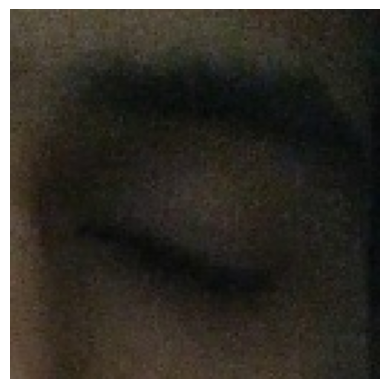

In [13]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def preview_random_image(folder_path):
    categories = [os.path.join(folder_path, cat) for cat in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, cat))]

    random_category = random.choice(categories)

    images = os.listdir(random_category)
    images = [img for img in images if img.endswith(('.png', '.jpg', '.jpeg'))]
    
    random_image_path = os.path.join(random_category, random.choice(images))

    img = Image.open(random_image_path)
    img = np.array(img)
    print(img.shape)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

folder_to_preview = '/content/datset/train'
preview_random_image(folder_to_preview)


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
def generators(train,val,test):
    train_datagen = ImageDataGenerator(1/255, zoom_range=0.1,
                                       shear_range=0.2,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2)
    val_datagen = ImageDataGenerator(1/255)
    test_datagen = ImageDataGenerator(1/255)

    train_gen = train_datagen.flow_from_directory(train,
                                                  batch_size=64,
                                                  class_mode='binary',
                                                  target_size=(128,128))
    val_gen = val_datagen.flow_from_directory(val,
                                              batch_size=64,
                                              class_mode='binary',
                                              target_size=(128,128))
    test_gen = val_datagen.flow_from_directory(test,
                                              batch_size=64,
                                              class_mode='binary',
                                              target_size=(128,128))
    return train_gen, val_gen, test_gen

In [15]:
train_path, val_path, test_path = '/content/datset/train', '/content/datset/validation', '/content/datset/test'

In [18]:
train_generator, val_generator, test_generator = generators(train_path, val_path, test_path)

Found 73394 images belonging to 2 classes.
Found 14679 images belonging to 2 classes.
Found 9787 images belonging to 2 classes.


In [19]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.callbacks import Callback
import tensorflow as tf
from tensorflow.keras.regularizers import l2

In [27]:
def create_model():
    input = Input(shape=(128, 128, 3))
    c1 = Conv2D(32, (3,3), activation='relu')(input)
    c2 = Conv2D(32, (3,3), activation='relu')(c1)
    m1 = MaxPooling2D((2,2))(c2)
    c3 = Conv2D(64, (3,3), activation='relu')(m1)
    c4 = Conv2D(64, (3,3), activation='relu')(c3)
    c5 = Conv2D(64, (3,3), activation='relu')(c4)
    m3 = MaxPooling2D((4,4))(c5)
    c6 = Conv2D(128, (3,3), activation='relu')(m3)
    m4 = MaxPooling2D((4,4))(c6)
    f1 = Flatten()(m4)
    dense1 = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(f1)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(1, activation='sigmoid')(dropout1)
    model = Model(inputs=input, outputs=[dense2])

    model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model


In [36]:
class Mycallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.98 and logs.get('accuracy') > 0.98:
            self.model.stop_training = True
callback = Mycallback()

In [29]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch):
    return 2e-4 * (0.98 ** epoch)
lr_scheduler =  LearningRateScheduler(scheduler)


In [38]:
model = create_model()
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 15, 15, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 28800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       7,373,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,465,217 (28.48 MB)

 Trainable params: 7,465,217 (28.48 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(train_generator, epochs=1, verbose=1, validation_data=val_generator)

1147/1147 ━━━━━━━━━━━━━━━━━━━━ 343s 294ms/step - accuracy: 0.8528 - loss: 4.2842 - val_accuracy: 0.9618 - val_loss: 0.4466


In [40]:
history = model.fit(train_generator, epochs=20, verbose=1, validation_data=val_generator, callbacks=[callback, lr_scheduler])

Epoch 1/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 341s 296ms/step - accuracy: 0.9482 - loss: 0.4478 - val_accuracy: 0.9697 - val_loss: 0.3407 - learning_rate: 2.0000e-04
Epoch 2/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 341s 296ms/step - accuracy: 0.9604 - loss: 0.3564 - val_accuracy: 0.9768 - val_loss: 0.2776 - learning_rate: 1.9600e-04
Epoch 3/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 385s 299ms/step - accuracy: 0.9696 - loss: 0.2863 - val_accuracy: 0.9830 - val_loss: 0.2150 - learning_rate: 1.9208e-04
Epoch 4/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 339s 294ms/step - accuracy: 0.9705 - loss: 0.2377 - val_accuracy: 0.9865 - val_loss: 0.1679 - learning_rate: 1.8824e-04
Epoch 5/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 344s 297ms/step - accuracy: 0.9735 - loss: 0.1964 - val_accuracy: 0.9869 - val_loss: 0.1399 - learning_rate: 1.8447e-04
Epoch 6/20
1147/1147 ━━━━━━━━━━━━━━━━━━━━ 340s 294ms/step - accuracy: 0.9769 - loss: 0.1622 - val_accuracy: 0.9862 - val_loss: 0.1237 - learning_rate: 1.8078e-04
Epoch 7/20
1147/1147 ━━━━━━━

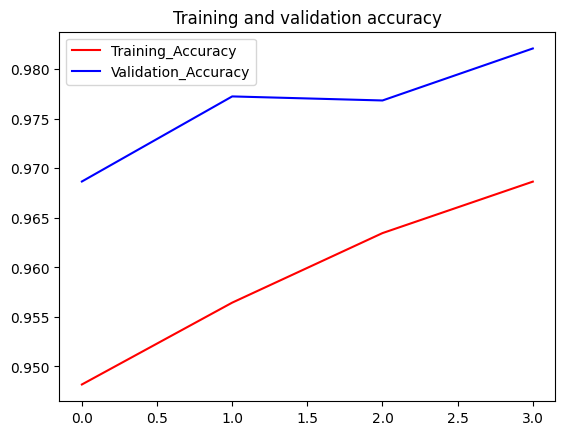

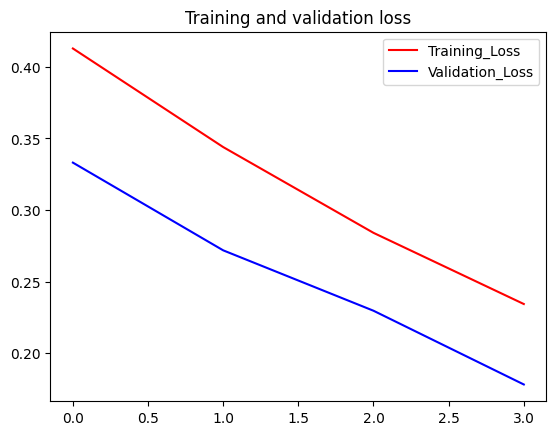

<Figure size 640x480 with 0 Axes>

In [35]:
train_accuracy = history.history.get('accuracy')
val_accuracy = history.history.get('val_accuracy')

train_loss = history.history.get('loss')
val_loss = history.history.get('val_loss')

epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, 'r', label='Training_Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation_Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_loss, 'r', label='Training_Loss')
plt.plot(epochs, val_loss, 'b', label='Validation_Loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.show()

In [45]:
pre = model.evaluate(test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


  1/153 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 1.0000 - loss: 0.0652

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


153/153 ━━━━━━━━━━━━━━━━━━━━ 12s 80ms/step - accuracy: 0.9892 - loss: 0.0916


In [41]:
model.save('eye_v1.keras')
